In [1]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, Conv1D, MaxPooling1D, Flatten
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.utils import np_utils
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

In [2]:
listening_history = pd.read_csv('../data/listening_history.csv', sep='\t')
id_metadata = pd.read_csv('../data/id_metadata.csv', sep='\t')
id_information = pd.read_csv('../data/id_information.csv', sep='\t')

In [3]:
listening_history.head()

,user,song,timestamp
0,user_007XIjOr,DaTQ53TUmfP93FSr,2019-02-20 12:28
1,user_007XIjOr,dGeyvi5WCOjDU7da,2019-02-20 12:35
2,user_007XIjOr,qUm54NYOjeFhmKYx,2019-02-20 12:48
3,user_007XIjOr,FtnuMT1DlevSR2n5,2019-02-20 12:52
4,user_007XIjOr,LHETTZcSZLeaVOGh,2019-02-20 13:09


In [4]:
id_metadata.head()

,id,spotify_id,popularity,release,danceability,energy,key,mode,valence,tempo,duration_ms
0,0009fFIM1eYThaPg,3eObKIfHKJ1nAPh0wTxFCc,12.0,2009,0.635,0.746,6.0,1.0,0.548,110.973,229947
1,0010xmHR6UICBOYT,27szvF97Tu95GxN98N52fy,46.0,2013,0.591,0.513,7.0,0.0,0.263,172.208,325096
2,002Jyd0vN4HyCpqL,273lBFpxUCwisTpdnF9cVb,31.0,1974,0.319,0.925,2.0,1.0,0.658,157.630,285693
3,006TYKNjNxWjfKjy,1qZgergQ41vaD4zBf3AKXR,33.0,2017,0.432,0.979,7.0,1.0,0.162,90.008,332867
4,007LIJOPQ4Sb98qV,6rVxJ3sN3Cz40MSLavbG1K,19.0,2009,0.357,0.708,9.0,1.0,0.470,123.904,326067


In [5]:
selected_features = id_metadata.copy()
selected_features = selected_features.drop(columns=['spotify_id'])
selected_features.set_index("id", inplace=True)
selected_features

,popularity,release,danceability,energy,key,mode,valence,tempo,duration_ms
id,,,,,,,,,
0009fFIM1eYThaPg,12.0,2009,0.635,0.746,6.0,1.0,0.548,110.973,229947
0010xmHR6UICBOYT,46.0,2013,0.591,0.513,7.0,0.0,0.263,172.208,325096
002Jyd0vN4HyCpqL,31.0,1974,0.319,0.925,2.0,1.0,0.658,157.630,285693
006TYKNjNxWjfKjy,33.0,2017,0.432,0.979,7.0,1.0,0.162,90.008,332867
007LIJOPQ4Sb98qV,19.0,2009,0.357,0.708,9.0,1.0,0.470,123.904,326067
...,...,...,...,...,...,...,...,...,...
zzyyPUs7hC9Nz2e1,36.0,2017,0.380,0.835,1.0,1.0,0.539,142.699,200880
zzz0n04uuTUA7fNh,48.0,2014,0.572,0.503,6.0,0.0,0.553,103.215,262840
zzzj3LYaZtYtbzSr,21.0,2010,0.402,0.376,2.0,0.0,0.119,108.509,276507


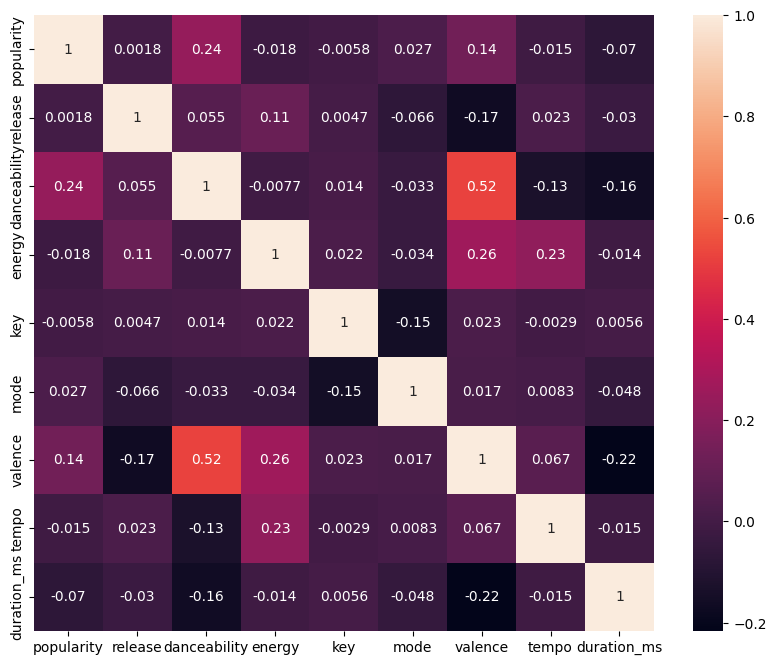

In [6]:
plt.figure(figsize=(10, 8)) 
ax = sns.heatmap(selected_features.corr(), annot=True)
plt.show()

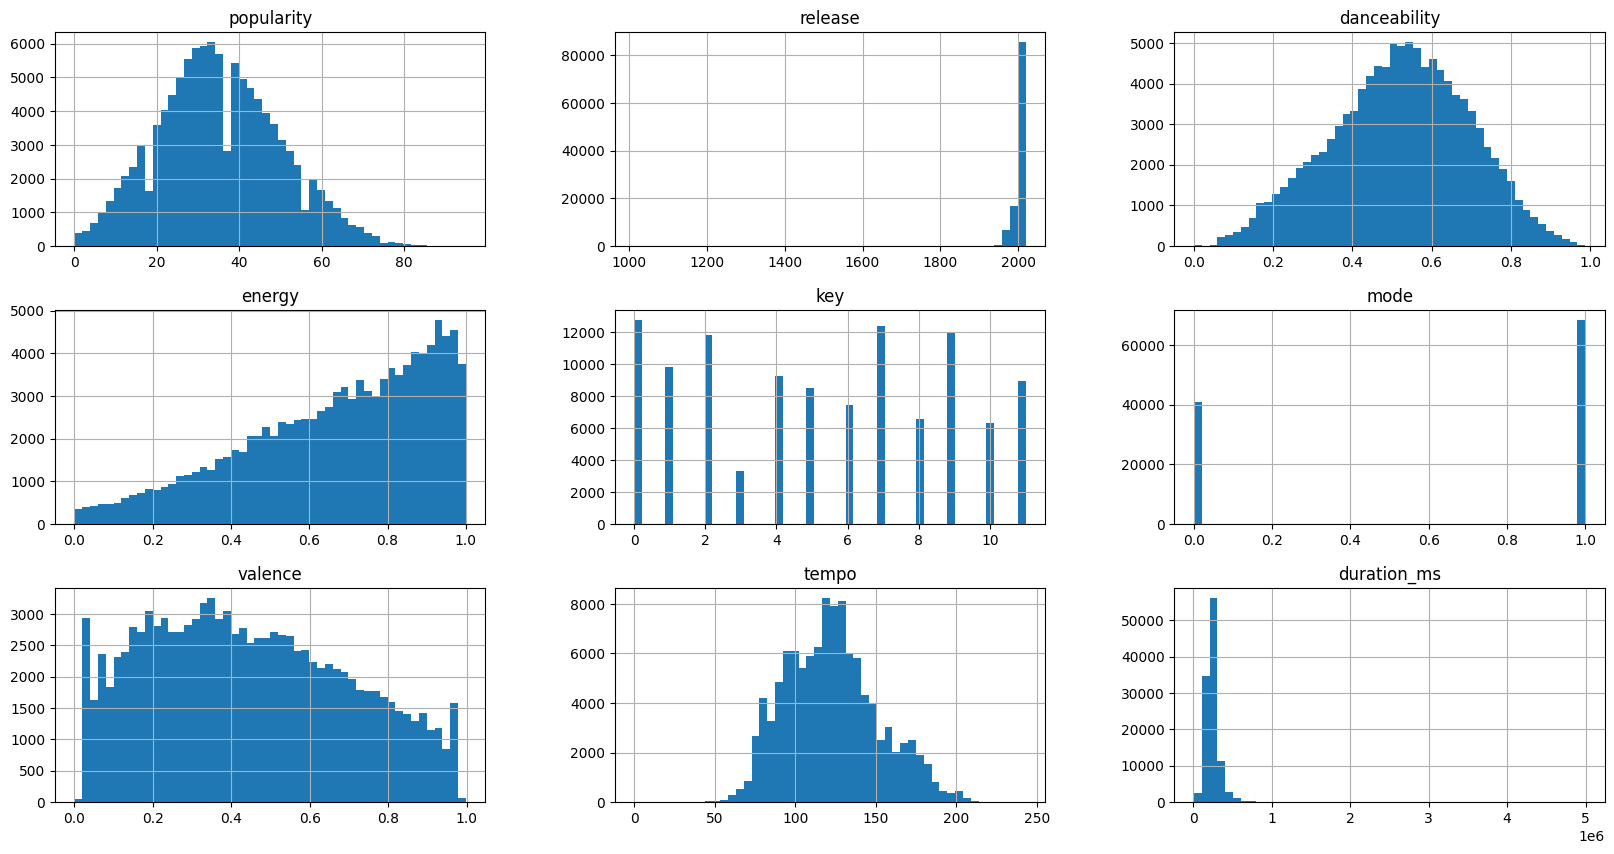

In [7]:
selected_features.hist(bins=50, figsize=(20,10))
plt.show()

In [8]:
columns_to_cluster = ['popularity', 'release', 'danceability', 'energy',
                      'key', 'mode', 'valence', 'tempo', 'duration_ms']

In [9]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
songs_scaled = scaler.fit_transform(selected_features)

In [10]:
columns_to_cluster_scaled = ['scaled_popularity', 'scaled_release', 'scaled_danceability', 'scaled_energy',
                      'scaled_key', 'scaled_mode', 'scaled_valence', 'scaled_tempo', 'scaled_duration_ms']

df_songs_scaled = pd.DataFrame(songs_scaled, columns=columns_to_cluster_scaled)
df_songs_scaled.head()

,scaled_popularity,scaled_release,scaled_danceability,scaled_energy,scaled_key,scaled_mode,scaled_valence,scaled_tempo,scaled_duration_ms
0,-1.564131,0.222289,0.662116,0.326627,0.201057,0.775143,0.406477,-0.406239,-0.125156
1,0.739987,0.501327,0.407792,-0.638693,0.481895,-1.290084,-0.723768,1.705473,0.823152
2,-0.276535,-2.219289,-1.164394,1.068225,-0.922292,0.775143,0.842712,1.202745,0.430439
3,-0.140999,0.780364,-0.511243,1.291948,0.481895,0.775143,-1.124311,-1.129225,0.900602
4,-1.089753,0.222289,-0.944751,0.169193,1.043569,0.775143,0.097147,0.039692,0.832829


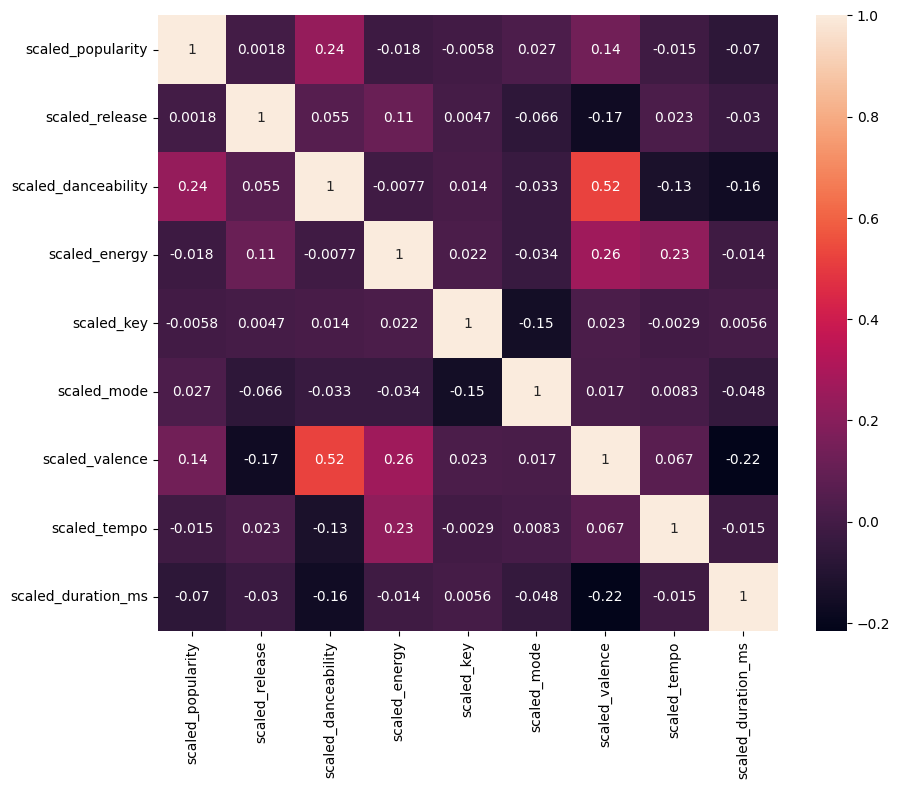

In [11]:
plt.figure(figsize=(10, 8)) 
ax = sns.heatmap(df_songs_scaled.corr(), annot=True)
plt.show()

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

n_clusters = range(2,30)
ssd = []
sc = []


for n in n_clusters:
    km = KMeans(n_clusters=n, max_iter=300, n_init=10, init='k-means++', random_state=42)
    km.fit(songs_scaled)
    preds = km.predict(songs_scaled) 
    centers = km.cluster_centers_ 
    ssd.append(km.inertia_) 
    score = silhouette_score(songs_scaled, preds, metric='euclidean')
    sc.append(score)
    print("Number of Clusters = {}, Silhouette Score = {}".format(n, score))

Number of Clusters = 2, Silhouette Score = 0.12582544643386753
Number of Clusters = 3, Silhouette Score = 0.12205862626556352
Number of Clusters = 4, Silhouette Score = 0.12304172368769987
Number of Clusters = 5, Silhouette Score = 0.12342854829317738
Number of Clusters = 6, Silhouette Score = 0.1267600754713731
Number of Clusters = 7, Silhouette Score = 0.12285055671392263
Number of Clusters = 8, Silhouette Score = 0.11738288147673283
Number of Clusters = 9, Silhouette Score = 0.11124239879272692
Number of Clusters = 10, Silhouette Score = 0.11619475953474502
Number of Clusters = 11, Silhouette Score = 0.11190071377234706
Number of Clusters = 12, Silhouette Score = 0.11339673932059229
Number of Clusters = 13, Silhouette Score = 0.11164511253263014
Number of Clusters = 14, Silhouette Score = 0.11429777890541885


In [ ]:
plt.plot(n_clusters, sc, marker='.', markersize=12, color='red')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.title('Silhouette score behavior over the number of clusters')
plt.show()

plt.plot(n_clusters, ssd, marker='.', markersize=12)
plt.xlabel('Number of clusters')
plt.ylabel('Sum of squared distances')
plt.title('Elbow method for optimal K')
plt.show()

In [ ]:
selected_features['cluster'] = preds

In [ ]:
selected_features.to_csv('../helpers/selected_features_clustered.csv')

In [ ]:
selected_features_clustered = pd.read_csv('../helpers/selected_features_clustered.csv', sep=',')
selected_features_clustered.set_index("id", inplace=True)
selected_features_clustered

In [ ]:
selected_features_clustered.groupby('cluster').count()

In [ ]:
preds

In [ ]:
X = selected_features_clustered.drop(columns=['cluster'])
y = selected_features_clustered['cluster']

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Normalize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

In [ ]:
# One-hot encode the target labels
y_train_encoded = to_categorical(y_train)
y_val_encoded = to_categorical(y_val)

In [ ]:
# Build the neural network
model = Sequential()
model.add(Dense(64, activation='relu', input_dim=X_train.shape[1]))
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(y_val_encoded.shape[1], activation='softmax'))  # Use 'softmax' for multi-class problems


In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print(model.summary())


In [ ]:
# Train the model using the one-hot encoded labels
history = model.fit(X_train, y_train_encoded, validation_data=(X_val, y_val_encoded), epochs=25, batch_size=64, verbose=0)

In [ ]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
from numpy import argmax
# Evaluate the model
y_pred_train = model.predict(X_train)
y_pred_val = model.predict(X_val)

# Convert predictions from one-hot encoded to class labels
y_pred_train = argmax(y_pred_train, axis=1)
y_pred_val = argmax(y_pred_val, axis=1)

train_acc = accuracy_score(y_train, y_pred_train)
val_acc = accuracy_score(y_val, y_pred_val)

print(f"Training Accuracy: {train_acc}")
print(f"Validation Accuracy: {val_acc}")

# Confusion Matrix
cm_train = confusion_matrix(y_train, y_pred_train)
print("Confusion Matrix:")
print(cm_train)

In [ ]:
sample = selected_features_clustered.sample(n=1)
inputs = scaler.transform(sample.drop(columns=['cluster']))
predicted = selected_features_clustered[selected_features_clustered['cluster'] == argmax(model.predict(inputs))].sort_values(by=['popularity'], ascending= False).head(1)
print("Input: \n",
      "id: ", sample.index.values[0],
      "\n",
      "cluster: ", sample['cluster'].values[0],
      "\n",
      "artist: ", id_information.loc[id_information['id'] == sample.index.values[0]].artist.values[0],
      "\n",
      "song: ", id_information.loc[id_information['id'] == sample.index.values[0]].song.values[0] 
     )
print("Predicted: \n",
      "id: ", predicted.index.values[0],
      "\n",
      "cluster: ", predicted.cluster.values[0],
      "\n",
      "artist: ", id_information.loc[id_information['id'] == predicted.index.values[0]].artist.values[0],
      "\n",
      "song: ", id_information.loc[id_information['id'] == predicted.index.values[0]].song.values[0] 
     )

In [ ]:
sample

In [ ]:
predicted